In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

%load_ext autoreload
%autoreload 2

os.chdir('/content/drive/MyDrive/PR202010770/Lab04/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

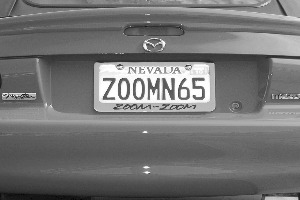

In [7]:
## 0. 입력 Gray scale로 읽기

image = cv2.imread('image/car01.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (300, 200))
cv2_imshow(image)

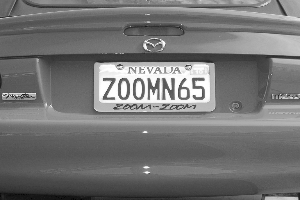

In [8]:
## 1. 가우시안 스무딩
gaus_img = cv2.GaussianBlur(image, (5, 5), 0.3)
cv2_imshow(gaus_img)

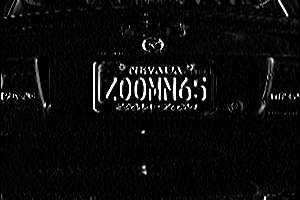

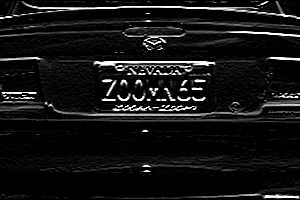

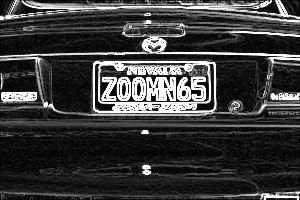

In [9]:
## 2. 결과 영상에 소벨 연산자를 적용하여 에지 강도와 방향 맵 구하기

Gx = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 1, 0, 3)  # x방향 마스크
Gy = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 0, 1, 3)  # y방향 마스크
sobel = np.fabs(Gx) + np.fabs(Gy)  # 두 행렬 절댓값 덧셈

directs = cv2.phase(Gx, Gy) / (np.pi / 4)  # cv2.phase로 두 행렬간의 각도 계산 (출력은 라디안), pi/4로 나누어 ?
directs = directs.astype(int) % 4

cv2_imshow(Gx)
cv2_imshow(Gy)
cv2_imshow(sobel)

In [10]:
directs = cv2.phase(Gx, Gy) / (np.pi / 4)  # cv2.phase로 두 행렬간의 각도 계산 (출력은 라디안), pi/4로 나누어 ?
directs = directs.astype(int) % 4
directs

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 3, ..., 0, 2, 2],
       [2, 1, 0, ..., 3, 3, 2],
       ...,
       [2, 3, 3, ..., 2, 3, 2],
       [2, 3, 3, ..., 3, 3, 2],
       [0, 0, 0, ..., 0, 0, 0]])

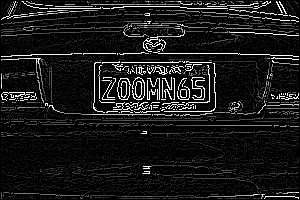

In [11]:
## 3. 비최대 억제를 적용하여 얇은 두께 에지 맵 생성

def nonmax_suppression(sobel, directs): #비 최대치 억제 함수
    rows, cols = sobel.shape[:2]
    dst = np.zeros((rows, cols),np.float32)
    for i in range(1, rows-1):
        for j in range(1, cols-1):          #행렬 처리를 통해 이웃 화소 가져오기
            values = sobel[i-1:i+2,j-1:j+2].flatten()
            first = [3, 0, 1, 2]
            id = first[directs[i, j]]
            v1, v2 = values[id], values[8-id]
            dst[i, j] = sobel[i, j] if (v1 < sobel[i,j] > v2) else 0
    return dst

max_sobel = nonmax_suppression(sobel, directs) #비최대치 억제
cv2_imshow(max_sobel)

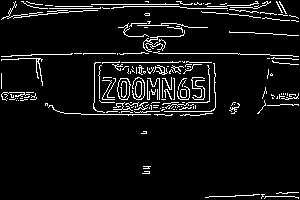

In [12]:
## 4. 임계값(threshold)을 적용하여 거짓 긍정 제거

def trace(max_sobel, i, j, low, pos_ck, canny):
    h, w = max_sobel.shape
    if (0 <= 1 < h and 0 <= j < w) == False: return # 추척 화소 범위 확인
    if pos_ck[i, j] == 0 and max_sobel[i, j] > low:
        pos_ck[i,j] = 255
        canny[i, j] = 255

        trace(max_sobel, i-1, j-1, low, pos_ck, canny)  #추적 함수 재귀 호출 - 8방향 추적
        trace(max_sobel, i  , j-1, low, pos_ck, canny)
        trace(max_sobel, i+1, j-1, low, pos_ck, canny)
        trace(max_sobel, i-1, j  , low, pos_ck, canny)
        trace(max_sobel, i+1, j  , low, pos_ck, canny)
        trace(max_sobel, i-1, j+1, low, pos_ck, canny)
        trace(max_sobel, i  , j+1, low, pos_ck, canny)
        trace(max_sobel, i+1, j+1, low, pos_ck, canny)

def hysteresis(max_sobel, low, high): #이력 임계값 수행
    pos_ck = np.zeros(max_sobel.shape[:2], np.uint8)
    canny = np.zeros(max_sobel.shape[:2], np.uint8)

    rows, cols = max_sobel.shape[:2]
    for i in range(1, rows-1):  # 에지 영상 순회
        for j in range(1, cols-1):
            if max_sobel[i,j] > high:
                trace(max_sobel, i, j, low, pos_ck, canny) #추적 시
    return canny

canny= hysteresis(max_sobel, 100, 200)  #이력 임계값
cv2_imshow(canny)

## 3. 학습을 통해 컨볼루션 필터 만들기

In [13]:
import tensorflow as tf

# MNIST 데이터셋 로드
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0  # 이미지 정규화
X_train = np.expand_dims(X_train, axis=-1)  # 채널 차원 추가 (64, 64, 1)

# 학습에 사용할 데이터 크기 제한
X_train = X_train[:1000]  # 예제에서는 1000개만 사용

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


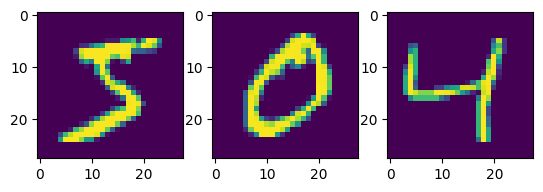

In [14]:
# 이미지 시각화
plt.subplot(1, 3, 1)
plt.imshow(X_train[0])
plt.subplot(1, 3, 2)
plt.imshow(X_train[1])
plt.subplot(1, 3, 3)
plt.imshow(X_train[2])
plt.show()

In [15]:
# 필터(커널) 생성: 3x3 필터
true_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
true_kernel = true_kernel.reshape((3, 3, 1, 1))  # (height, width, input_channels, output_channels)

# 필터를 적용하여 출력 이미지 (Y) 생성
Y_train = tf.nn.conv2d(X_train, true_kernel, strides=1, padding='SAME').numpy()

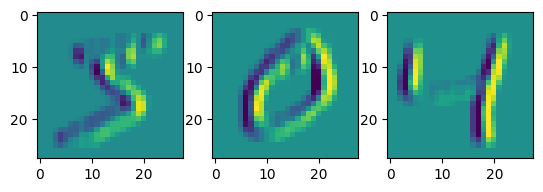

In [16]:
# 결과 이미지 시각화
plt.subplot(1, 3, 1)
plt.imshow(Y_train[0])
plt.subplot(1, 3, 2)
plt.imshow(Y_train[1])
plt.subplot(1, 3, 3)
plt.imshow(Y_train[2])
plt.show()

In [17]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 학습 전 커널(필터) 출력
initial_kernel = model.layers[0].get_weights()[0]
print("학습전 커널 (필터):\n", initial_kernel)

# 모델 학습
model.fit(X_train, Y_train, epochs=100)

# 학습된 커널(필터) 출력
learned_kernel = model.layers[0].get_weights()[0]
print("학습된 커널 (필터):\n", learned_kernel)

# 실제 커널과 학습된 커널 비교
print("실제 커널 (필터):\n", true_kernel)

학습전 커널 (필터):
 [[[[ 0.51513946]]

  [[-0.485209  ]]

  [[ 0.1942643 ]]]


 [[[-0.4432494 ]]

  [[-0.06498146]]

  [[ 0.14196074]]]


 [[[-0.5275729 ]]

  [[-0.5709861 ]]

  [[-0.33643797]]]]
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8665
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7961
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7529
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6889
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6440
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5983
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5502
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5163
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4816
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4564
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4166
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3887
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3579
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3293
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3083
Epoch 1

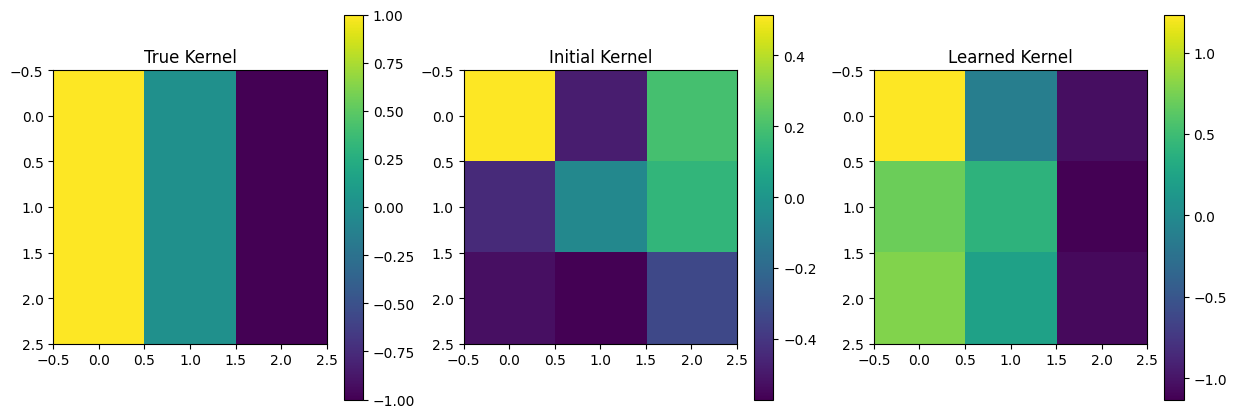

In [18]:
# 서브플롯 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 첫 번째 이미지: true_kernel
im1 = axes[0].imshow(true_kernel.reshape(3, 3))
axes[0].set_title("True Kernel")
fig.colorbar(im1, ax=axes[0])  # 첫 번째 서브플롯에 colorbar 추가

# 두 번째 이미지: initial_kernel
im2 = axes[1].imshow(initial_kernel.reshape(3, 3))
axes[1].set_title("Initial Kernel")
fig.colorbar(im2, ax=axes[1])  # 두 번째 서브플롯에 colorbar 추가

# 세 번째 이미지: learned_kernel
im3 = axes[2].imshow(learned_kernel.reshape(3, 3))
axes[2].set_title("Learned Kernel")
fig.colorbar(im3, ax=axes[2])  # 세 번째 서브플롯에 colorbar 추가

# 그래프 표시
plt.show()

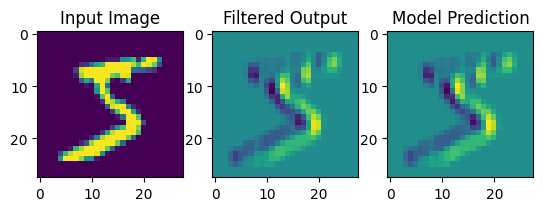

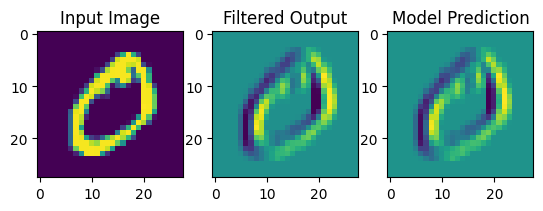

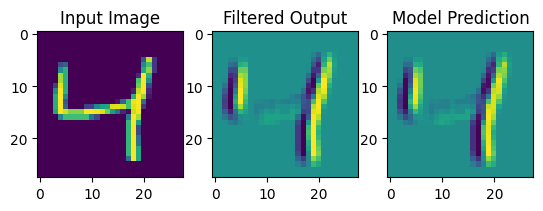

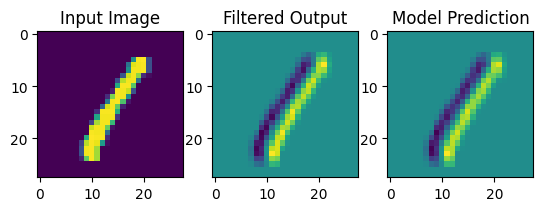

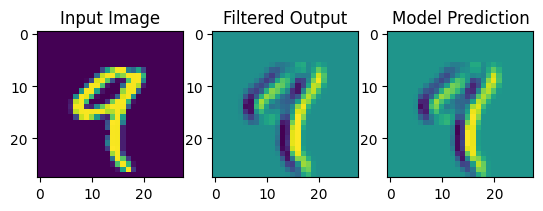

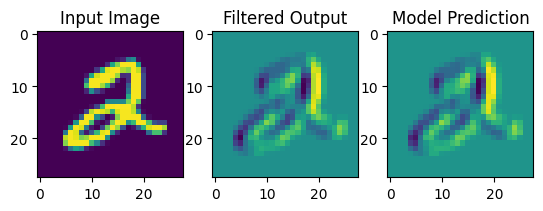

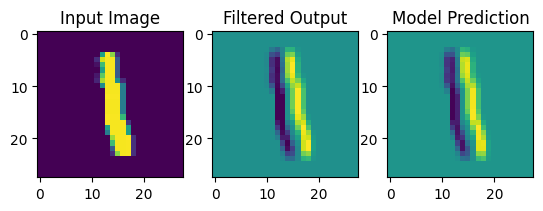

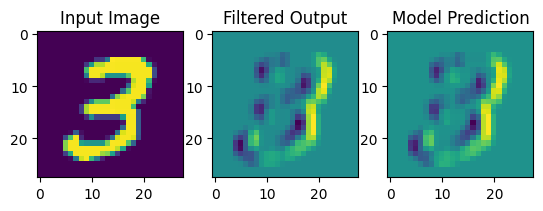

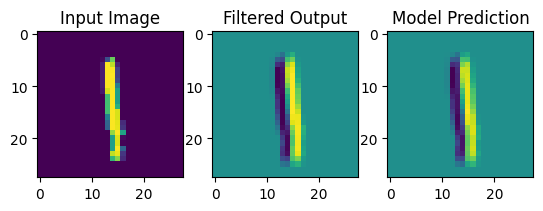

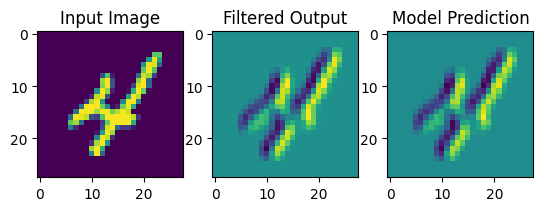

In [19]:
for idx in range(10):
    # 입력 데이터
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[idx])
    plt.title("Input Image")

    # 필터 적용된 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(Y_train[idx])
    plt.title("Filtered Output")

    # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
    predicted_output = model(X_train[idx].reshape((1, 28, 28, 1))).numpy()
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_output.reshape(28, 28))
    plt.title("Model Prediction")

    plt.show()

## CNN 모델로 Canny Edge Detection 구현해보기


In [20]:
import tensorflow as tf
import numpy as np
import cv2

#MNIST 데이터셋 로드
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0 #이미지 정규화

# Canny edge detection 적용함수
def apply_canny_edge_detection(images):
    edge_images = []
    for img in images:
        edge_img = cv2.Canny((img*255).astype(np.uint8), 100, 200) # Canny edge 적용
        edge_images.append(edge_img)
    return np.array(edge_images)

# 채널 차원 추가
X_train = np.expand_dims(X_train, axis=-1) # (28, 28, 1)

# 데이터 크기 제한
X_train = X_train[:1000] # 1000개만 사용

#Canny edge detection 적용
Y_train = apply_canny_edge_detection(X_train.squeeze(axis=-1)) #채널 제거 후 적용
Y_train = np.expand_dims(Y_train, axis=-1) # (28, 28, 1)로 모양 맞춤

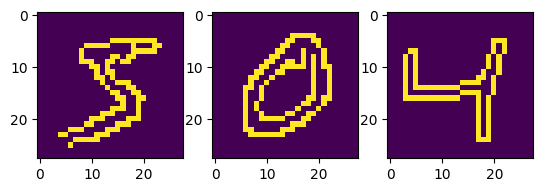

In [21]:
plt.subplot(1,3,1)
plt.imshow(Y_train[0])
plt.subplot(1,3,2)
plt.imshow(Y_train[1])
plt.subplot(1,3,3)
plt.imshow(Y_train[2])
plt.show()

In [22]:
#CNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])
#모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

#학습 전 커널(필터) 출력
initial_kernel = model.layers[0].get_weights()[0]
print("학습 전 커널 (필터):\n", initial_kernel)

#모델 학습
model.fit(X_train, Y_train, epochs=100)

#학습된 커널(필터) 출력
learned_kernel = model.layers[0].get_weights()[0]
print("학습 후 커널 (필터):\n", learned_kernel)

학습 전 커널 (필터):
 [[[[-0.14823145]]

  [[ 0.17226583]]

  [[ 0.16488898]]]


 [[[ 0.29006845]]

  [[-0.14407521]]

  [[-0.51903814]]]


 [[[ 0.36160803]]

  [[ 0.22976184]]

  [[ 0.02333403]]]]
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7100.6484
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6993.3198
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7007.4639
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7101.3237
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7040.4263
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7038.9380
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6964.1831
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6991.1699
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7018.2925
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6976.6797
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6967.0166
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

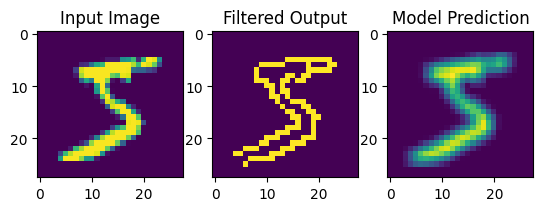

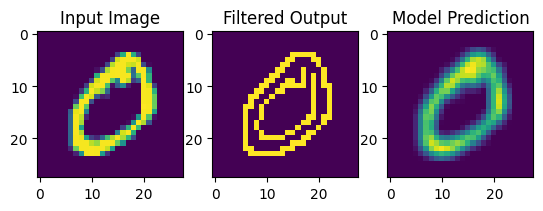

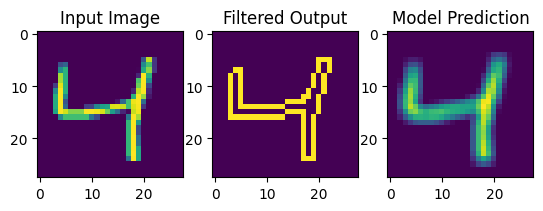

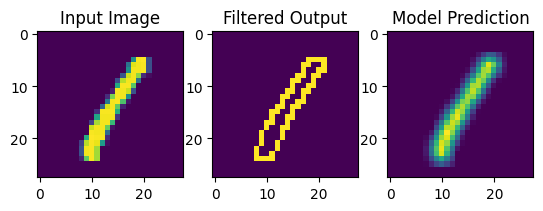

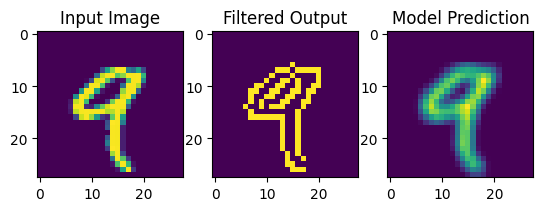

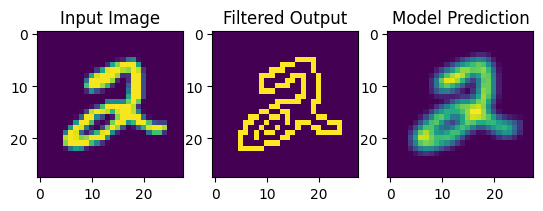

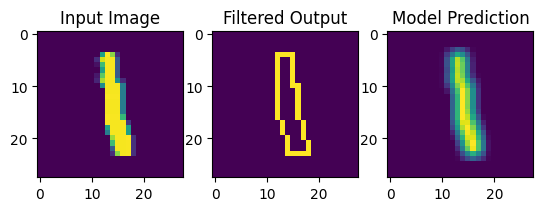

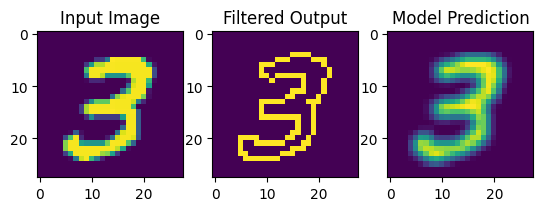

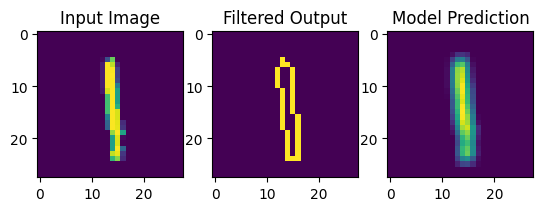

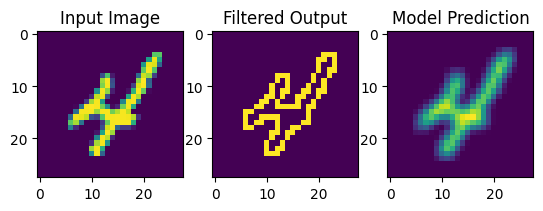

In [23]:
for idx in range(10):
    #입력 데이터
    plt.subplot(1,3,1)
    plt.imshow(X_train[idx])
    plt.title("Input Image")
    #필터 적용된 이미지
    plt.subplot(1,3,2)
    plt.imshow(Y_train[idx])
    plt.title("Filtered Output")
    #모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
    predixted_output = model(X_train[idx].reshape(1, 28, 28, 1)).numpy()
    plt.subplot(1,3,3)
    plt.imshow(predixted_output.reshape(28, 28))
    plt.title("Model Prediction")
    plt.show()

In [24]:
# CNN 모델 정의 (깊고 필터 수를 많이 사용)
model_deep = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),

    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same')  # 출력 채널은 1개
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model_deep.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model_deep.fit(X_train, Y_train, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 6802.9692
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 4819.9180
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 4645.6807
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 4527.5146
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - loss: 4363.2769
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 4046.9016
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - loss: 3457.0925
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 2906.2068
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - loss: 2517.4937
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 2149.4944
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - loss: 1882.2822
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - loss: 1615.9391
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 1416.8754
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 1221.0254


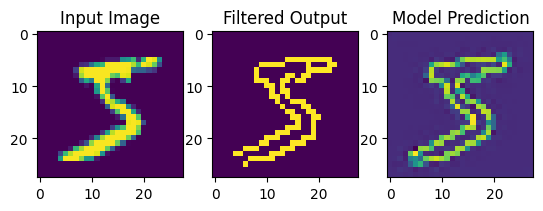

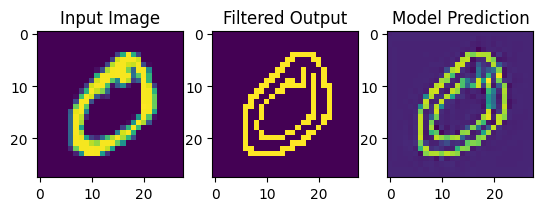

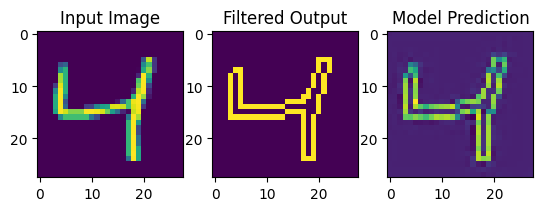

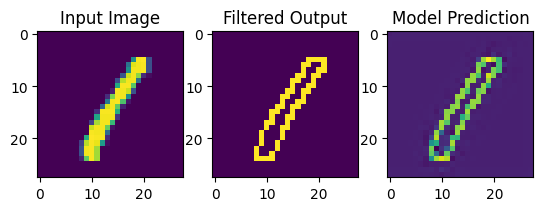

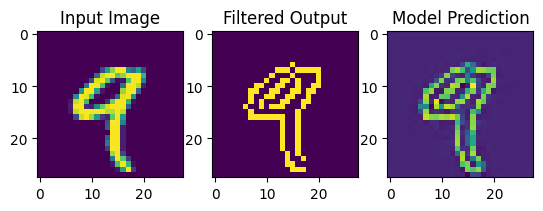

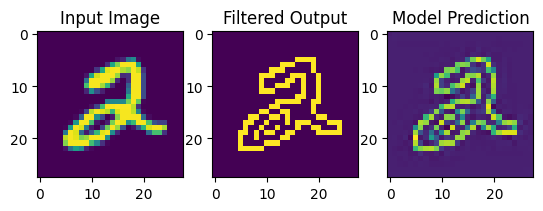

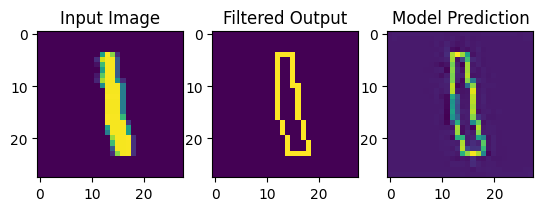

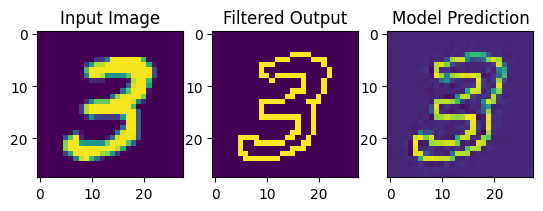

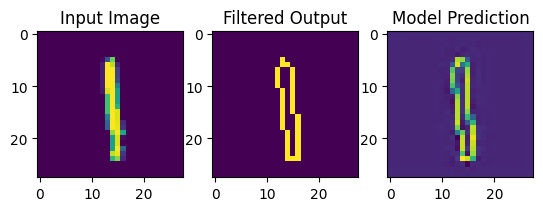

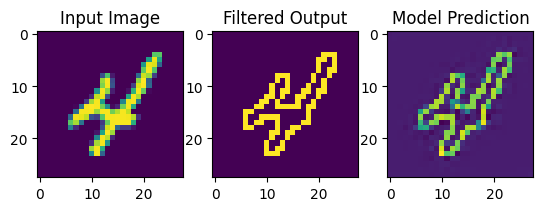

In [25]:
for idx in range(10):
    # 입력 데이터
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[idx])
    plt.title("Input Image")

    # 필터 적용된 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(Y_train[idx])
    plt.title("Filtered Output")

    # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
    predicted_output_deep = model_deep(X_train[idx].reshape((1, 28, 28, 1))).numpy()
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_output_deep.reshape(28, 28))
    plt.title("Model Prediction")

    plt.show()

In [27]:
!jupyter nbconvert --to html "Lab04_202010770.ipynb"

[NbConvertApp] Converting notebook Lab04_202010770.ipynb to html
[NbConvertApp] Writing 1557041 bytes to Lab04_202010770.html
